<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Run-ModBP-to-identify-partitions" data-toc-modified-id="Run-ModBP-to-identify-partitions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Run ModBP to identify partitions</a></span></li><li><span><a href="#Run-CHAMP" data-toc-modified-id="Run-CHAMP-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Run CHAMP</a></span></li></ul></div>

In [10]:
from __future__ import print_function
import numpy as np
import pandas as pd
import os 
import modbp
import champ
import matplotlib as mpl
import matplotlib.image as mpimg

import sklearn.metrics as skm 
import gzip,pickle
import seaborn as sbn
import matplotlib.colors as mc 
import matplotlib.colorbar as mcb
mpl.rcParams['figure.facecolor']='white'
import matplotlib.pyplot as plt
def adjacency_to_edges(A):
    nnz_inds = np.nonzero(A)
    nnzvals = np.array(A[nnz_inds])
    if len(nnzvals.shape) > 1:
        nnzvals = nnzvals[0]  # handle scipy sparse types
    return list(zip(nnz_inds[0], nnz_inds[1], nnzvals))

law_datdir='./LazegaLawyers/'
outdatdir='./'
attributes=pd.read_table(os.path.join(law_datdir,'ELattr.dat'),sep=' ',index_col=0,header=None)
print('attributes',attributes.shape)
attributes.index=attributes.index-1
work=pd.read_table(os.path.join(law_datdir,'ELwork.dat'),sep=' ',header=None)
print ('work:{}'.format(work.shape))
advice=pd.read_table(os.path.join(law_datdir,'ELadv.dat'),sep=' ',header=None)
print ('advice:{}'.format(advice.shape))
friend=pd.read_table(os.path.join(law_datdir,'ELfriend.dat'),sep=' ',header=None)
print ('friend:{}'.format(friend.shape))

layer2name={0:'work',1:'advice',2:'friend'}
n=work.shape[0]
super_adj=np.zeros((3*n,3*n))
super_adj[:n,:n]=work.as_matrix()
super_adj[n:2*n,n:2*n]=advice.as_matrix()
super_adj[2*n:3*n,2*n:3*n]=friend.as_matrix()

inter_elist=[(i,i+n) for i in range(n)]+\
    [(i,2*n+i) for i in range(n)]+\
    [(i+n,i+2*n) for i in range(n)]

intra_elist=adjacency_to_edges(super_adj)

C_adj=np.zeros((3*n,3*n))
for e1,e2 in inter_elist:
    C_adj[e1,e2]=1
    C_adj[e2,e1]=1

intra_elist=adjacency_to_edges(super_adj)
#
inter_elist=[(i,i+n) for i in range(n)]+\
    [(i+n,2*n+i) for i in range(n)]+\
    [(2*n+i,i) for i in range(n)]
    
C=np.zeros((3*n,3*n))
for i,j in inter_elist:
    C[i,j]=1
    C[j,i]=1
# C+=C.T
layer_vec=np.array([ i//n for i in range(3*n)])

mgraph=modbp.MultilayerGraph(interlayer_edges=inter_elist,
                            intralayer_edges=intra_elist,
                            layer_vec=layer_vec)



attributes (71, 7)
work:(71, 71)
advice:(71, 71)
friend:(71, 71)


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


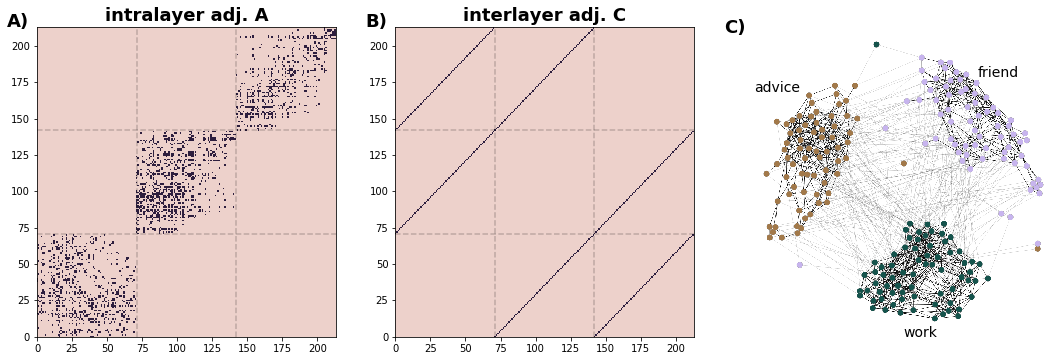

In [13]:
cmap=sbn.cubehelix_palette(as_cmap=True)
plt.close()
f,a=plt.subplots(1,3,figsize=(15,5))

a=plt.subplot(1,3,1)
a.set_title("intralayer adj. A",fontsize=18,fontweight='bold')
a.text(s='A)',x=-.1,y=1.0,transform=a.transAxes,
       fontsize=18,fontweight='bold')
plt.pcolormesh(super_adj,cmap=cmap)
a.vlines(x=[71,142],ymin=0,ymax=213,linestyle='--',color=(0,0,0,.2))
a.hlines(y=[71,142],xmin=0,xmax=213,linestyle='--',color=(0,0,0,.2))

a=plt.subplot(1,3,2)
a.set_title("interlayer adj. C",fontsize=18,fontweight='bold')
a.text(s='B)',x=-.1,y=1.0,transform=a.transAxes,
       fontsize=18,fontweight='bold')
plt.pcolormesh(C_adj,cmap=cmap)
a.vlines(x=[71,142],ymin=0,ymax=213,linestyle='--',color=(0,0,0,.2))
a.hlines(y=[71,142],xmin=0,xmax=213,linestyle='--',color=(0,0,0,.2))

a=plt.subplot(1,3,3)
graph_img="./lawyer_combined.png"
im=mpimg.imread(graph_img)
a.set_axis_off()
plt.imshow(im)
a.text(s='C)',x=-.1,y=1.0,transform=a.transAxes,
       fontsize=18,fontweight='bold')

#THESE COULD CHANGE! 
a.text(s='work',x=.5,y=-.02,transform=a.transAxes,
       fontsize=14)
a.text(s='friend',x=.75,y=.85,transform=a.transAxes,
       fontsize=14)
a.text(s='advice',x=.0,y=.8,transform=a.transAxes,
       fontsize=14)

f.subplots_adjust(top=.93,bottom=.07,right=.99,left=.05)
f.savefig(os.path.join(outdatdir,'lawyer_with_adjacencies.png'),dpi=200)
plt.show()

# Run ModBP to identify partitions

In [30]:
#100x100 grid space
gammas=np.linspace(0,3,100)
omegas=np.linspace(0,3,100)

qmax=7
modbp_obj=modbp.ModularityBP(mlgraph=mgraph,accuracy_off=True
                             ,use_effective=True,align_communities_across_layers_multiplex=True)
for gamma in gammas:
    print('gamma : {}'.format(gamma),end=" , ")
    for omega in omegas:
        print('omega: {}'.format(omega),end=' , ')
        
        bstars=[modbp_obj.get_bstar(omega=omega,q=x) for x in range(2,qmax)]
        not_conv=0
        for beta in bstars:
            #print("beta: {}".format(beta),end=' , ')
            modbp_obj.run_modbp(beta=beta,q=qmax,niter=500,omega=omega,resgamma=gamma)
            rm_df=modbp_obj.retrieval_modularities
            #could short cut if reach region of betas where consistently not converging. 
            if rm_df.iloc[-1,:]['converged']==False:
                not_conv+=1

    print()

gamma : 0.0 , omega: 0.0 , omega: 0.030303030303030304 , omega: 0.06060606060606061 , omega: 0.09090909090909091 , omega: 0.12121212121212122 , omega: 0.15151515151515152 , omega: 0.18181818181818182 , omega: 0.21212121212121213 , omega: 0.24242424242424243 , omega: 0.2727272727272727 , omega: 0.30303030303030304 , omega: 0.33333333333333337 , omega: 0.36363636363636365 , omega: 0.3939393939393939 , omega: 0.42424242424242425 , omega: 0.4545454545454546 , omega: 0.48484848484848486 , omega: 0.5151515151515151 , omega: 0.5454545454545454 , omega: 0.5757575757575758 , omega: 0.6060606060606061 , omega: 0.6363636363636364 , omega: 0.6666666666666667 , omega: 0.696969696969697 , omega: 0.7272727272727273 , omega: 0.7575757575757576 , omega: 0.7878787878787878 , omega: 0.8181818181818182 , omega: 0.8484848484848485 , omega: 0.8787878787878788 , omega: 0.9090909090909092 , omega: 0.9393939393939394 , omega: 0.9696969696969697 , omega: 1.0 , omega: 1.0303030303030303 , omega: 1.06060606060606

gamma : 0.12121212121212122 , omega: 0.0 , omega: 0.030303030303030304 , omega: 0.06060606060606061 , omega: 0.09090909090909091 , omega: 0.12121212121212122 , omega: 0.15151515151515152 , omega: 0.18181818181818182 , omega: 0.21212121212121213 , omega: 0.24242424242424243 , omega: 0.2727272727272727 , omega: 0.30303030303030304 , omega: 0.33333333333333337 , omega: 0.36363636363636365 , omega: 0.3939393939393939 , omega: 0.42424242424242425 , omega: 0.4545454545454546 , omega: 0.48484848484848486 , omega: 0.5151515151515151 , omega: 0.5454545454545454 , omega: 0.5757575757575758 , omega: 0.6060606060606061 , omega: 0.6363636363636364 , omega: 0.6666666666666667 , omega: 0.696969696969697 , omega: 0.7272727272727273 , omega: 0.7575757575757576 , omega: 0.7878787878787878 , omega: 0.8181818181818182 , omega: 0.8484848484848485 , omega: 0.8787878787878788 , omega: 0.9090909090909092 , omega: 0.9393939393939394 , omega: 0.9696969696969697 , omega: 1.0 , omega: 1.0303030303030303 , omega: 

gamma : 0.24242424242424243 , omega: 0.0 , omega: 0.030303030303030304 , omega: 0.06060606060606061 , omega: 0.09090909090909091 , omega: 0.12121212121212122 , omega: 0.15151515151515152 , omega: 0.18181818181818182 , omega: 0.21212121212121213 , omega: 0.24242424242424243 , omega: 0.2727272727272727 , omega: 0.30303030303030304 , omega: 0.33333333333333337 , omega: 0.36363636363636365 , omega: 0.3939393939393939 , omega: 0.42424242424242425 , omega: 0.4545454545454546 , omega: 0.48484848484848486 , omega: 0.5151515151515151 , omega: 0.5454545454545454 , omega: 0.5757575757575758 , omega: 0.6060606060606061 , omega: 0.6363636363636364 , omega: 0.6666666666666667 , omega: 0.696969696969697 , omega: 0.7272727272727273 , omega: 0.7575757575757576 , omega: 0.7878787878787878 , omega: 0.8181818181818182 , omega: 0.8484848484848485 , omega: 0.8787878787878788 , omega: 0.9090909090909092 , omega: 0.9393939393939394 , omega: 0.9696969696969697 , omega: 1.0 , omega: 1.0303030303030303 , omega: 

gamma : 0.36363636363636365 , omega: 0.0 , omega: 0.030303030303030304 , omega: 0.06060606060606061 , omega: 0.09090909090909091 , omega: 0.12121212121212122 , omega: 0.15151515151515152 , omega: 0.18181818181818182 , omega: 0.21212121212121213 , omega: 0.24242424242424243 , omega: 0.2727272727272727 , omega: 0.30303030303030304 , omega: 0.33333333333333337 , omega: 0.36363636363636365 , omega: 0.3939393939393939 , omega: 0.42424242424242425 , omega: 0.4545454545454546 , omega: 0.48484848484848486 , omega: 0.5151515151515151 , omega: 0.5454545454545454 , omega: 0.5757575757575758 , omega: 0.6060606060606061 , omega: 0.6363636363636364 , omega: 0.6666666666666667 , omega: 0.696969696969697 , omega: 0.7272727272727273 , omega: 0.7575757575757576 , omega: 0.7878787878787878 , omega: 0.8181818181818182 , omega: 0.8484848484848485 , omega: 0.8787878787878788 , omega: 0.9090909090909092 , omega: 0.9393939393939394 , omega: 0.9696969696969697 , omega: 1.0 , omega: 1.0303030303030303 , omega: 

gamma : 0.48484848484848486 , omega: 0.0 , omega: 0.030303030303030304 , omega: 0.06060606060606061 , omega: 0.09090909090909091 , omega: 0.12121212121212122 , omega: 0.15151515151515152 , omega: 0.18181818181818182 , omega: 0.21212121212121213 , omega: 0.24242424242424243 , omega: 0.2727272727272727 , omega: 0.30303030303030304 , omega: 0.33333333333333337 , omega: 0.36363636363636365 , omega: 0.3939393939393939 , omega: 0.42424242424242425 , omega: 0.4545454545454546 , omega: 0.48484848484848486 , omega: 0.5151515151515151 , omega: 0.5454545454545454 , omega: 0.5757575757575758 , omega: 0.6060606060606061 , omega: 0.6363636363636364 , omega: 0.6666666666666667 , omega: 0.696969696969697 , omega: 0.7272727272727273 , omega: 0.7575757575757576 , omega: 0.7878787878787878 , omega: 0.8181818181818182 , omega: 0.8484848484848485 , omega: 0.8787878787878788 , omega: 0.9090909090909092 , omega: 0.9393939393939394 , omega: 0.9696969696969697 , omega: 1.0 , omega: 1.0303030303030303 , omega: 

gamma : 0.6060606060606061 , omega: 0.0 , omega: 0.030303030303030304 , omega: 0.06060606060606061 , omega: 0.09090909090909091 , omega: 0.12121212121212122 , omega: 0.15151515151515152 , omega: 0.18181818181818182 , omega: 0.21212121212121213 , omega: 0.24242424242424243 , omega: 0.2727272727272727 , omega: 0.30303030303030304 , omega: 0.33333333333333337 , omega: 0.36363636363636365 , omega: 0.3939393939393939 , omega: 0.42424242424242425 , omega: 0.4545454545454546 , omega: 0.48484848484848486 , omega: 0.5151515151515151 , omega: 0.5454545454545454 , omega: 0.5757575757575758 , omega: 0.6060606060606061 , omega: 0.6363636363636364 , omega: 0.6666666666666667 , omega: 0.696969696969697 , omega: 0.7272727272727273 , omega: 0.7575757575757576 , omega: 0.7878787878787878 , omega: 0.8181818181818182 , omega: 0.8484848484848485 , omega: 0.8787878787878788 , omega: 0.9090909090909092 , omega: 0.9393939393939394 , omega: 0.9696969696969697 , omega: 1.0 , omega: 1.0303030303030303 , omega: 1

gamma : 0.7272727272727273 , omega: 0.0 , omega: 0.030303030303030304 , omega: 0.06060606060606061 , omega: 0.09090909090909091 , omega: 0.12121212121212122 , omega: 0.15151515151515152 , omega: 0.18181818181818182 , omega: 0.21212121212121213 , omega: 0.24242424242424243 , omega: 0.2727272727272727 , omega: 0.30303030303030304 , omega: 0.33333333333333337 , omega: 0.36363636363636365 , omega: 0.3939393939393939 , omega: 0.42424242424242425 , omega: 0.4545454545454546 , omega: 0.48484848484848486 , omega: 0.5151515151515151 , omega: 0.5454545454545454 , omega: 0.5757575757575758 , omega: 0.6060606060606061 , omega: 0.6363636363636364 , omega: 0.6666666666666667 , omega: 0.696969696969697 , omega: 0.7272727272727273 , omega: 0.7575757575757576 , omega: 0.7878787878787878 , omega: 0.8181818181818182 , omega: 0.8484848484848485 , omega: 0.8787878787878788 , omega: 0.9090909090909092 , omega: 0.9393939393939394 , omega: 0.9696969696969697 , omega: 1.0 , omega: 1.0303030303030303 , omega: 1

gamma : 0.8484848484848485 , omega: 0.0 , omega: 0.030303030303030304 , omega: 0.06060606060606061 , omega: 0.09090909090909091 , omega: 0.12121212121212122 , omega: 0.15151515151515152 , omega: 0.18181818181818182 , omega: 0.21212121212121213 , omega: 0.24242424242424243 , omega: 0.2727272727272727 , omega: 0.30303030303030304 , omega: 0.33333333333333337 , omega: 0.36363636363636365 , omega: 0.3939393939393939 , omega: 0.42424242424242425 , omega: 0.4545454545454546 , omega: 0.48484848484848486 , omega: 0.5151515151515151 , omega: 0.5454545454545454 , omega: 0.5757575757575758 , omega: 0.6060606060606061 , omega: 0.6363636363636364 , omega: 0.6666666666666667 , omega: 0.696969696969697 , omega: 0.7272727272727273 , omega: 0.7575757575757576 , omega: 0.7878787878787878 , omega: 0.8181818181818182 , omega: 0.8484848484848485 , omega: 0.8787878787878788 , omega: 0.9090909090909092 , omega: 0.9393939393939394 , omega: 0.9696969696969697 , omega: 1.0 , omega: 1.0303030303030303 , omega: 1

gamma : 0.9696969696969697 , omega: 0.0 , omega: 0.030303030303030304 , omega: 0.06060606060606061 , omega: 0.09090909090909091 , omega: 0.12121212121212122 , omega: 0.15151515151515152 , omega: 0.18181818181818182 , omega: 0.21212121212121213 , omega: 0.24242424242424243 , omega: 0.2727272727272727 , omega: 0.30303030303030304 , omega: 0.33333333333333337 , omega: 0.36363636363636365 , omega: 0.3939393939393939 , omega: 0.42424242424242425 , omega: 0.4545454545454546 , omega: 0.48484848484848486 , omega: 0.5151515151515151 , omega: 0.5454545454545454 , omega: 0.5757575757575758 , omega: 0.6060606060606061 , omega: 0.6363636363636364 , omega: 0.6666666666666667 , omega: 0.696969696969697 , omega: 0.7272727272727273 , omega: 0.7575757575757576 , omega: 0.7878787878787878 , omega: 0.8181818181818182 , omega: 0.8484848484848485 , omega: 0.8787878787878788 , omega: 0.9090909090909092 , omega: 0.9393939393939394 , omega: 0.9696969696969697 , omega: 1.0 , omega: 1.0303030303030303 , omega: 1

gamma : 1.0909090909090908 , omega: 0.0 , omega: 0.030303030303030304 , omega: 0.06060606060606061 , omega: 0.09090909090909091 , omega: 0.12121212121212122 , omega: 0.15151515151515152 , omega: 0.18181818181818182 , omega: 0.21212121212121213 , omega: 0.24242424242424243 , omega: 0.2727272727272727 , omega: 0.30303030303030304 , omega: 0.33333333333333337 , omega: 0.36363636363636365 , omega: 0.3939393939393939 , omega: 0.42424242424242425 , omega: 0.4545454545454546 , omega: 0.48484848484848486 , omega: 0.5151515151515151 , omega: 0.5454545454545454 , omega: 0.5757575757575758 , omega: 0.6060606060606061 , omega: 0.6363636363636364 , omega: 0.6666666666666667 , omega: 0.696969696969697 , omega: 0.7272727272727273 , omega: 0.7575757575757576 , omega: 0.7878787878787878 , omega: 0.8181818181818182 , omega: 0.8484848484848485 , omega: 0.8787878787878788 , omega: 0.9090909090909092 , omega: 0.9393939393939394 , omega: 0.9696969696969697 , omega: 1.0 , omega: 1.0303030303030303 , omega: 1

gamma : 1.2121212121212122 , omega: 0.0 , omega: 0.030303030303030304 , omega: 0.06060606060606061 , omega: 0.09090909090909091 , omega: 0.12121212121212122 , omega: 0.15151515151515152 , omega: 0.18181818181818182 , omega: 0.21212121212121213 , omega: 0.24242424242424243 , omega: 0.2727272727272727 , omega: 0.30303030303030304 , omega: 0.33333333333333337 , omega: 0.36363636363636365 , omega: 0.3939393939393939 , omega: 0.42424242424242425 , omega: 0.4545454545454546 , omega: 0.48484848484848486 , omega: 0.5151515151515151 , omega: 0.5454545454545454 , omega: 0.5757575757575758 , omega: 0.6060606060606061 , omega: 0.6363636363636364 , omega: 0.6666666666666667 , omega: 0.696969696969697 , omega: 0.7272727272727273 , omega: 0.7575757575757576 , omega: 0.7878787878787878 , omega: 0.8181818181818182 , omega: 0.8484848484848485 , omega: 0.8787878787878788 , omega: 0.9090909090909092 , omega: 0.9393939393939394 , omega: 0.9696969696969697 , omega: 1.0 , omega: 1.0303030303030303 , omega: 1

gamma : 1.3333333333333335 , omega: 0.0 , omega: 0.030303030303030304 , omega: 0.06060606060606061 , omega: 0.09090909090909091 , omega: 0.12121212121212122 , omega: 0.15151515151515152 , omega: 0.18181818181818182 , omega: 0.21212121212121213 , omega: 0.24242424242424243 , omega: 0.2727272727272727 , omega: 0.30303030303030304 , omega: 0.33333333333333337 , omega: 0.36363636363636365 , omega: 0.3939393939393939 , omega: 0.42424242424242425 , omega: 0.4545454545454546 , omega: 0.48484848484848486 , omega: 0.5151515151515151 , omega: 0.5454545454545454 , omega: 0.5757575757575758 , omega: 0.6060606060606061 , omega: 0.6363636363636364 , omega: 0.6666666666666667 , omega: 0.696969696969697 , omega: 0.7272727272727273 , omega: 0.7575757575757576 , omega: 0.7878787878787878 , omega: 0.8181818181818182 , omega: 0.8484848484848485 , omega: 0.8787878787878788 , omega: 0.9090909090909092 , omega: 0.9393939393939394 , omega: 0.9696969696969697 , omega: 1.0 , omega: 1.0303030303030303 , omega: 1

gamma : 1.4545454545454546 , omega: 0.0 , omega: 0.030303030303030304 , omega: 0.06060606060606061 , omega: 0.09090909090909091 , omega: 0.12121212121212122 , omega: 0.15151515151515152 , omega: 0.18181818181818182 , omega: 0.21212121212121213 , omega: 0.24242424242424243 , omega: 0.2727272727272727 , omega: 0.30303030303030304 , omega: 0.33333333333333337 , omega: 0.36363636363636365 , omega: 0.3939393939393939 , omega: 0.42424242424242425 , omega: 0.4545454545454546 , omega: 0.48484848484848486 , omega: 0.5151515151515151 , omega: 0.5454545454545454 , omega: 0.5757575757575758 , omega: 0.6060606060606061 , omega: 0.6363636363636364 , omega: 0.6666666666666667 , omega: 0.696969696969697 , omega: 0.7272727272727273 , omega: 0.7575757575757576 , omega: 0.7878787878787878 , omega: 0.8181818181818182 , omega: 0.8484848484848485 , omega: 0.8787878787878788 , omega: 0.9090909090909092 , omega: 0.9393939393939394 , omega: 0.9696969696969697 , omega: 1.0 , omega: 1.0303030303030303 , omega: 1

gamma : 1.5757575757575757 , omega: 0.0 , omega: 0.030303030303030304 , omega: 0.06060606060606061 , omega: 0.09090909090909091 , omega: 0.12121212121212122 , omega: 0.15151515151515152 , omega: 0.18181818181818182 , omega: 0.21212121212121213 , omega: 0.24242424242424243 , omega: 0.2727272727272727 , omega: 0.30303030303030304 , omega: 0.33333333333333337 , omega: 0.36363636363636365 , omega: 0.3939393939393939 , omega: 0.42424242424242425 , omega: 0.4545454545454546 , omega: 0.48484848484848486 , omega: 0.5151515151515151 , omega: 0.5454545454545454 , omega: 0.5757575757575758 , omega: 0.6060606060606061 , omega: 0.6363636363636364 , omega: 0.6666666666666667 , omega: 0.696969696969697 , omega: 0.7272727272727273 , omega: 0.7575757575757576 , omega: 0.7878787878787878 , omega: 0.8181818181818182 , omega: 0.8484848484848485 , omega: 0.8787878787878788 , omega: 0.9090909090909092 , omega: 0.9393939393939394 , omega: 0.9696969696969697 , omega: 1.0 , omega: 1.0303030303030303 , omega: 1

gamma : 1.696969696969697 , omega: 0.0 , omega: 0.030303030303030304 , omega: 0.06060606060606061 , omega: 0.09090909090909091 , omega: 0.12121212121212122 , omega: 0.15151515151515152 , omega: 0.18181818181818182 , omega: 0.21212121212121213 , omega: 0.24242424242424243 , omega: 0.2727272727272727 , omega: 0.30303030303030304 , omega: 0.33333333333333337 , omega: 0.36363636363636365 , omega: 0.3939393939393939 , omega: 0.42424242424242425 , omega: 0.4545454545454546 , omega: 0.48484848484848486 , omega: 0.5151515151515151 , omega: 0.5454545454545454 , omega: 0.5757575757575758 , omega: 0.6060606060606061 , omega: 0.6363636363636364 , omega: 0.6666666666666667 , omega: 0.696969696969697 , omega: 0.7272727272727273 , omega: 0.7575757575757576 , omega: 0.7878787878787878 , omega: 0.8181818181818182 , omega: 0.8484848484848485 , omega: 0.8787878787878788 , omega: 0.9090909090909092 , omega: 0.9393939393939394 , omega: 0.9696969696969697 , omega: 1.0 , omega: 1.0303030303030303 , omega: 1.

gamma : 1.8181818181818183 , omega: 0.0 , omega: 0.030303030303030304 , omega: 0.06060606060606061 , omega: 0.09090909090909091 , omega: 0.12121212121212122 , omega: 0.15151515151515152 , omega: 0.18181818181818182 , omega: 0.21212121212121213 , omega: 0.24242424242424243 , omega: 0.2727272727272727 , omega: 0.30303030303030304 , omega: 0.33333333333333337 , omega: 0.36363636363636365 , omega: 0.3939393939393939 , omega: 0.42424242424242425 , omega: 0.4545454545454546 , omega: 0.48484848484848486 , omega: 0.5151515151515151 , omega: 0.5454545454545454 , omega: 0.5757575757575758 , omega: 0.6060606060606061 , omega: 0.6363636363636364 , omega: 0.6666666666666667 , omega: 0.696969696969697 , omega: 0.7272727272727273 , omega: 0.7575757575757576 , omega: 0.7878787878787878 , omega: 0.8181818181818182 , omega: 0.8484848484848485 , omega: 0.8787878787878788 , omega: 0.9090909090909092 , omega: 0.9393939393939394 , omega: 0.9696969696969697 , omega: 1.0 , omega: 1.0303030303030303 , omega: 1

gamma : 1.9393939393939394 , omega: 0.0 , omega: 0.030303030303030304 , omega: 0.06060606060606061 , omega: 0.09090909090909091 , omega: 0.12121212121212122 , omega: 0.15151515151515152 , omega: 0.18181818181818182 , omega: 0.21212121212121213 , omega: 0.24242424242424243 , omega: 0.2727272727272727 , omega: 0.30303030303030304 , omega: 0.33333333333333337 , omega: 0.36363636363636365 , omega: 0.3939393939393939 , omega: 0.42424242424242425 , omega: 0.4545454545454546 , omega: 0.48484848484848486 , omega: 0.5151515151515151 , omega: 0.5454545454545454 , omega: 0.5757575757575758 , omega: 0.6060606060606061 , omega: 0.6363636363636364 , omega: 0.6666666666666667 , omega: 0.696969696969697 , omega: 0.7272727272727273 , omega: 0.7575757575757576 , omega: 0.7878787878787878 , omega: 0.8181818181818182 , omega: 0.8484848484848485 , omega: 0.8787878787878788 , omega: 0.9090909090909092 , omega: 0.9393939393939394 , omega: 0.9696969696969697 , omega: 1.0 , omega: 1.0303030303030303 , omega: 1

gamma : 2.0606060606060606 , omega: 0.0 , omega: 0.030303030303030304 , omega: 0.06060606060606061 , omega: 0.09090909090909091 , omega: 0.12121212121212122 , omega: 0.15151515151515152 , omega: 0.18181818181818182 , omega: 0.21212121212121213 , omega: 0.24242424242424243 , omega: 0.2727272727272727 , omega: 0.30303030303030304 , omega: 0.33333333333333337 , omega: 0.36363636363636365 , omega: 0.3939393939393939 , omega: 0.42424242424242425 , omega: 0.4545454545454546 , omega: 0.48484848484848486 , omega: 0.5151515151515151 , omega: 0.5454545454545454 , omega: 0.5757575757575758 , omega: 0.6060606060606061 , omega: 0.6363636363636364 , omega: 0.6666666666666667 , omega: 0.696969696969697 , omega: 0.7272727272727273 , omega: 0.7575757575757576 , omega: 0.7878787878787878 , omega: 0.8181818181818182 , omega: 0.8484848484848485 , omega: 0.8787878787878788 , omega: 0.9090909090909092 , omega: 0.9393939393939394 , omega: 0.9696969696969697 , omega: 1.0 , omega: 1.0303030303030303 , omega: 1

gamma : 2.1818181818181817 , omega: 0.0 , omega: 0.030303030303030304 , omega: 0.06060606060606061 , omega: 0.09090909090909091 , omega: 0.12121212121212122 , omega: 0.15151515151515152 , omega: 0.18181818181818182 , omega: 0.21212121212121213 , omega: 0.24242424242424243 , omega: 0.2727272727272727 , omega: 0.30303030303030304 , omega: 0.33333333333333337 , omega: 0.36363636363636365 , omega: 0.3939393939393939 , omega: 0.42424242424242425 , omega: 0.4545454545454546 , omega: 0.48484848484848486 , omega: 0.5151515151515151 , omega: 0.5454545454545454 , omega: 0.5757575757575758 , omega: 0.6060606060606061 , omega: 0.6363636363636364 , omega: 0.6666666666666667 , omega: 0.696969696969697 , omega: 0.7272727272727273 , omega: 0.7575757575757576 , omega: 0.7878787878787878 , omega: 0.8181818181818182 , omega: 0.8484848484848485 , omega: 0.8787878787878788 , omega: 0.9090909090909092 , omega: 0.9393939393939394 , omega: 0.9696969696969697 , omega: 1.0 , omega: 1.0303030303030303 , omega: 1

gamma : 2.303030303030303 , omega: 0.0 , omega: 0.030303030303030304 , omega: 0.06060606060606061 , omega: 0.09090909090909091 , omega: 0.12121212121212122 , omega: 0.15151515151515152 , omega: 0.18181818181818182 , omega: 0.21212121212121213 , omega: 0.24242424242424243 , omega: 0.2727272727272727 , omega: 0.30303030303030304 , omega: 0.33333333333333337 , omega: 0.36363636363636365 , omega: 0.3939393939393939 , omega: 0.42424242424242425 , omega: 0.4545454545454546 , omega: 0.48484848484848486 , omega: 0.5151515151515151 , omega: 0.5454545454545454 , omega: 0.5757575757575758 , omega: 0.6060606060606061 , omega: 0.6363636363636364 , omega: 0.6666666666666667 , omega: 0.696969696969697 , omega: 0.7272727272727273 , omega: 0.7575757575757576 , omega: 0.7878787878787878 , omega: 0.8181818181818182 , omega: 0.8484848484848485 , omega: 0.8787878787878788 , omega: 0.9090909090909092 , omega: 0.9393939393939394 , omega: 0.9696969696969697 , omega: 1.0 , omega: 1.0303030303030303 , omega: 1.

gamma : 2.4242424242424243 , omega: 0.0 , omega: 0.030303030303030304 , omega: 0.06060606060606061 , omega: 0.09090909090909091 , omega: 0.12121212121212122 , omega: 0.15151515151515152 , omega: 0.18181818181818182 , omega: 0.21212121212121213 , omega: 0.24242424242424243 , omega: 0.2727272727272727 , omega: 0.30303030303030304 , omega: 0.33333333333333337 , omega: 0.36363636363636365 , omega: 0.3939393939393939 , omega: 0.42424242424242425 , omega: 0.4545454545454546 , omega: 0.48484848484848486 , omega: 0.5151515151515151 , omega: 0.5454545454545454 , omega: 0.5757575757575758 , omega: 0.6060606060606061 , omega: 0.6363636363636364 , omega: 0.6666666666666667 , omega: 0.696969696969697 , omega: 0.7272727272727273 , omega: 0.7575757575757576 , omega: 0.7878787878787878 , omega: 0.8181818181818182 , omega: 0.8484848484848485 , omega: 0.8787878787878788 , omega: 0.9090909090909092 , omega: 0.9393939393939394 , omega: 0.9696969696969697 , omega: 1.0 , omega: 1.0303030303030303 , omega: 1

gamma : 2.5454545454545454 , omega: 0.0 , omega: 0.030303030303030304 , omega: 0.06060606060606061 , omega: 0.09090909090909091 , omega: 0.12121212121212122 , omega: 0.15151515151515152 , omega: 0.18181818181818182 , omega: 0.21212121212121213 , omega: 0.24242424242424243 , omega: 0.2727272727272727 , omega: 0.30303030303030304 , omega: 0.33333333333333337 , omega: 0.36363636363636365 , omega: 0.3939393939393939 , omega: 0.42424242424242425 , omega: 0.4545454545454546 , omega: 0.48484848484848486 , omega: 0.5151515151515151 , omega: 0.5454545454545454 , omega: 0.5757575757575758 , omega: 0.6060606060606061 , omega: 0.6363636363636364 , omega: 0.6666666666666667 , omega: 0.696969696969697 , omega: 0.7272727272727273 , omega: 0.7575757575757576 , omega: 0.7878787878787878 , omega: 0.8181818181818182 , omega: 0.8484848484848485 , omega: 0.8787878787878788 , omega: 0.9090909090909092 , omega: 0.9393939393939394 , omega: 0.9696969696969697 , omega: 1.0 , omega: 1.0303030303030303 , omega: 1

gamma : 2.666666666666667 , omega: 0.0 , omega: 0.030303030303030304 , omega: 0.06060606060606061 , omega: 0.09090909090909091 , omega: 0.12121212121212122 , omega: 0.15151515151515152 , omega: 0.18181818181818182 , omega: 0.21212121212121213 , omega: 0.24242424242424243 , omega: 0.2727272727272727 , omega: 0.30303030303030304 , omega: 0.33333333333333337 , omega: 0.36363636363636365 , omega: 0.3939393939393939 , omega: 0.42424242424242425 , omega: 0.4545454545454546 , omega: 0.48484848484848486 , omega: 0.5151515151515151 , omega: 0.5454545454545454 , omega: 0.5757575757575758 , omega: 0.6060606060606061 , omega: 0.6363636363636364 , omega: 0.6666666666666667 , omega: 0.696969696969697 , omega: 0.7272727272727273 , omega: 0.7575757575757576 , omega: 0.7878787878787878 , omega: 0.8181818181818182 , omega: 0.8484848484848485 , omega: 0.8787878787878788 , omega: 0.9090909090909092 , omega: 0.9393939393939394 , omega: 0.9696969696969697 , omega: 1.0 , omega: 1.0303030303030303 , omega: 1.

gamma : 2.787878787878788 , omega: 0.0 , omega: 0.030303030303030304 , omega: 0.06060606060606061 , omega: 0.09090909090909091 , omega: 0.12121212121212122 , omega: 0.15151515151515152 , omega: 0.18181818181818182 , omega: 0.21212121212121213 , omega: 0.24242424242424243 , omega: 0.2727272727272727 , omega: 0.30303030303030304 , omega: 0.33333333333333337 , omega: 0.36363636363636365 , omega: 0.3939393939393939 , omega: 0.42424242424242425 , omega: 0.4545454545454546 , omega: 0.48484848484848486 , omega: 0.5151515151515151 , omega: 0.5454545454545454 , omega: 0.5757575757575758 , omega: 0.6060606060606061 , omega: 0.6363636363636364 , omega: 0.6666666666666667 , omega: 0.696969696969697 , omega: 0.7272727272727273 , omega: 0.7575757575757576 , omega: 0.7878787878787878 , omega: 0.8181818181818182 , omega: 0.8484848484848485 , omega: 0.8787878787878788 , omega: 0.9090909090909092 , omega: 0.9393939393939394 , omega: 0.9696969696969697 , omega: 1.0 , omega: 1.0303030303030303 , omega: 1.

gamma : 2.909090909090909 , omega: 0.0 , omega: 0.030303030303030304 , omega: 0.06060606060606061 , omega: 0.09090909090909091 , omega: 0.12121212121212122 , omega: 0.15151515151515152 , omega: 0.18181818181818182 , omega: 0.21212121212121213 , omega: 0.24242424242424243 , omega: 0.2727272727272727 , omega: 0.30303030303030304 , omega: 0.33333333333333337 , omega: 0.36363636363636365 , omega: 0.3939393939393939 , omega: 0.42424242424242425 , omega: 0.4545454545454546 , omega: 0.48484848484848486 , omega: 0.5151515151515151 , omega: 0.5454545454545454 , omega: 0.5757575757575758 , omega: 0.6060606060606061 , omega: 0.6363636363636364 , omega: 0.6666666666666667 , omega: 0.696969696969697 , omega: 0.7272727272727273 , omega: 0.7575757575757576 , omega: 0.7878787878787878 , omega: 0.8181818181818182 , omega: 0.8484848484848485 , omega: 0.8787878787878788 , omega: 0.9090909090909092 , omega: 0.9393939393939394 , omega: 0.9696969696969697 , omega: 1.0 , omega: 1.0303030303030303 , omega: 1.

In [31]:
# save partitions an output
import gzip, pickle
modbp_save_dir=os.path.join(outdatdir,"lazega_lawyer_modbp")
if not os.path.exists(modbp_save_dir):
    os.makedirs(modbp_save_dir)
partitions_out=os.path.join(modbp_save_dir,"lawyer_modbp_partitions.gz")
marginals_out=os.path.join(modbp_save_dir,"lawyer_modbp_marginals.gz")
rmdf_out=os.path.join(modbp_save_dir,"lawyer_modbp_rm_df.gz")

with gzip.open(partitions_out,'wb') as fh:
    pickle.dump(modbp_obj.partitions,fh)
with gzip.open(marginals_out,'wb') as fh:
    pickle.dump(modbp_obj.marginals,fh)
with gzip.open(rmdf_out,'wb') as fh:
    pickle.dump(modbp_obj.retrieval_modularities,fh)

In [32]:
import scipy.stats as stats
def get_avg_entropy(marginal):
    entropies=[]
    for i in range(marginal.shape[0]):
        entropies.append(stats.entropy(marginal[i])/np.log(marginal.shape[1]))
    return np.mean(entropies)

for ind in modbp_obj.retrieval_modularities.index:
    if ind%1000==0:
        print(ind)
    modbp_obj.retrieval_modularities.loc[ind,'entropy']=get_avg_entropy(modbp_obj.marginals[ind])

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000


In [33]:
# Set AMI's with other attributes
# attributes_dict={'gender':2,'office':4,'practice':7}
atts=[
'status',
'gender', 
'office' ,
'years',
'age',
'practice',
'law school']
attributes_dict=dict(zip(atts,range(1,len(atts)+1)))
print(attributes_dict)
for ind in modbp_obj.partitions.keys():
    layers=[0,1,2]
    max_atts=[]
    max_amis=[]
    
    for layer in layers: 
        layer_amis=[]
        cinds=np.where(np.array(layer_vec)==layer)[0]
        for attr in attributes_dict.keys():
            name="{}_{}".format(attr,layer)
            cami=skm.adjusted_mutual_info_score(modbp_obj.partitions[ind][cinds], attributes[attributes_dict[attr]].values)
            modbp_obj.retrieval_modularities.loc[ind,name]=cami
            layer_amis.append(cami)
        max_amis.append(np.max(layer_amis))
        max_atts.append(list(attributes_dict.keys())[np.argmax(layer_amis)])
        
    modbp_obj.retrieval_modularities.loc[ind,'tot_max']=np.sum(max_amis)
    modbp_obj.retrieval_modularities.loc[ind,'layer_ami_max']=np.max(max_amis)
    modbp_obj.retrieval_modularities.loc[ind,'attr_max_layers']="_".join(max_atts)

{'status': 1, 'gender': 2, 'office': 3, 'years': 4, 'age': 5, 'practice': 6, 'law school': 7}


In [34]:
# modbp_obj.retrieval_modularities.sort_values('num_coms',ascending=False)

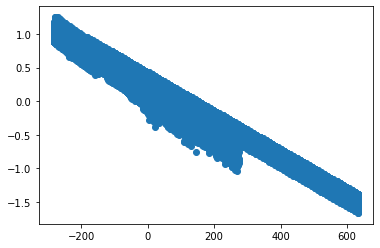

In [35]:
rm_df=modbp_obj.retrieval_modularities
plt.close()
plt.scatter(rm_df['bethe_free_energy'],rm_df['retrieval_modularity'])
plt.show()

In [36]:
# we remove all the partitions that haven't converged and that are trivial 
rm_df=modbp_obj.retrieval_modularities
print("starting: ",rm_df.shape)
rm_df=rm_df.iloc[np.where(rm_df['converged'])[0],:]
rm_df=rm_df[np.logical_not(rm_df['is_trivial'].values)]

# We take the partition that has the highest modularity for each resgamma omega pair (alternatively you could use maximum free energy)
rm_df=rm_df.loc[rm_df.groupby(['resgamma','omega'])['bethe_free_energy'].idxmin().values,:]
# rm_df=rm_df.loc[rm_df.groupby(['resgamma','omega'])['retrieval_modularity'].idxmax().values,:]

print("filtered: ",rm_df.shape)
layer_att_strs=np.array(['{}_{}'.format(k,layer) for k in attributes_dict.keys() for layer in [0,1,2]])
lay2keep=layer_att_strs[np.where(rm_df.loc[:,layer_att_strs].max()>.1)[0]]
ind2add=rm_df.loc[rm_df.loc[:,lay2keep].idxmax(axis=0),np.append(lay2keep,['resgamma','omega','tot_max','attr_max_layers'])].index.values
rm_df.loc[rm_df.loc[:,lay2keep].idxmax(axis=0),np.append(lay2keep,['resgamma','omega','tot_max','attr_max_layers'])]


starting:  (50000, 37)
filtered:  (5084, 37)


,status_2,gender_2,office_0,office_1,office_2,years_2,age_2,practice_0,practice_1,law school_2,resgamma,omega,tot_max,attr_max_layers
11557,0.377689,0.024530,4.964800e-01,2.186897e-01,0.418534,0.167105,0.061624,4.969031e-01,3.903321e-01,0.012084,0.696970,0.333333,1.305769,practice_practice_office
6994,0.050003,0.168155,7.535930e-01,-8.545871e-16,0.013520,-0.019892,-0.016624,-1.052037e-02,6.520204e-16,-0.029093,0.393939,2.969697,0.921748,office_gender_gender
7752,0.230110,-0.009074,8.504666e-01,-8.545871e-16,0.158068,0.173386,0.082650,-1.164575e-02,6.520204e-16,0.097991,0.454545,1.515152,1.080577,office_gender_status
8038,0.208171,-0.007339,5.562072e-01,8.504666e-01,0.072653,0.161354,0.062002,4.600828e-01,-1.164575e-02,0.048335,0.484848,0.212121,1.614845,office_office_status
7594,0.026669,-0.009484,6.642985e-01,-8.545871e-16,0.652876,-0.019188,0.003004,-8.101308e-03,6.520204e-16,-0.017600,0.454545,0.545455,1.317174,office_gender_office
5854,0.222034,-0.007395,-8.545871e-16,-8.545871e-16,0.044629,0.195494,0.106132,6.520204e-16,6.520204e-16,0.116327,0.333333,2.121212,0.222034,gender_gender_status
9477,0.257897,-0.004197,4.964800e-01,-8.545871e-16,0.041018,0.184718,0.127844,4.969031e-01,6.520204e-16,0.074640,0.545455,2.878788,0.754800,practice_gender_status
4014,0.000546,-0.012574,-1.918515e-03,-8.545871e-16,0.074966,-0.011000,-0.010859,9.049875e-01,6.520204e-16,-0.003445,0.242424,0.060606,0.979954,practice_gender_office
11579,0.329115,0.017862,4.964800e-01,5.201557e-01,0.491872,0.151706,0.061160,4.969031e-01,5.926062e-01,0.039196,0.696970,0.454545,1.581381,practice_practice_office
6929,0.222034,-0.007395,7.129222e-01,-8.545871e-16,0.044629,0.195494,0.106132,-1.256145e-02,6.520204e-16,0.116327,0.393939,2.575758,0.934957,office_gender_status


In [37]:
#add in all of the attributes and partitions to the network 
# for att in attributes_dict:
#     gt_graph.vp[att]=gt_graph.new_vp('int')
#     att_concat=np.concatenate([attributes[attributes_dict[att]] for _ in range(3)])
#     gt_graph.vp[att].a=att_concat
# for ind in ind2add:
#     cpart=modbp_obj.partitions[ind]
#     name="{}_{}".format(rm_df.loc[ind,'resgamma'],rm_df.loc[ind,'omega'])
#     gt_graph.vp[name]=gt_graph.new_vp('int')
#     gt_graph.vp[name].a=cpart

# gt_graph.vp['layer_vec']=gt_graph.new_vp('int')
# gt_graph.vp['layer_vec'].a=layer_vec
# gt_graph.vp['layer_name']=gt_graph.new_vp('string')
# gt_graph.vp['layer_name'].set_2d_array(np.array(map(lambda x: layer2name[x],layer_vec)))
# gt_graph.save('lawyers_combined.graphml.gz')

In [38]:
layer_att_strs=['{}_{}'.format(k,layer) for k in attributes_dict.keys() for layer in [0,1,2]]
modbp_obj.retrieval_modularities.loc[modbp_obj.retrieval_modularities.loc[:,layer_att_strs].idxmax(axis=0),:]

,q,beta,resgamma,omega,retrieval_modularity,niters,converged,bethe_free_energy,avg_entropy,num_coms,...,status_2,gender_2,office_2,years_2,age_2,practice_2,law school_2,tot_max,layer_ami_max,attr_max_layers
23060,7.0,0.546939,1.393939,0.363636,-0.095199,235.0,True,15.111737,0.990966,2.0,...,-0.013729,-0.014458,0.018804,-0.026879,0.016560,-0.010240,-0.010688,0.540696,0.311163,status_practice_office
35596,7.0,0.729388,2.151515,0.575758,0.023046,666.0,False,3.884766,0.652990,5.0,...,0.242690,-0.014071,0.410315,0.100764,-0.004973,-0.018723,0.020779,1.328691,0.464921,office_office_office
33711,7.0,0.673126,2.030303,1.272727,-0.119356,500.0,False,48.609140,0.923993,3.0,...,0.497720,0.081024,0.086287,0.234811,0.090314,-0.019400,0.027587,1.117155,0.596076,age_office_status
12615,7.0,0.533046,0.757576,0.696970,0.285101,88.0,True,-86.523856,0.915594,2.0,...,-0.012742,-0.000447,-0.017596,0.008286,-0.018471,-0.005809,-0.019481,0.523324,0.333922,gender_practice_years
22742,7.0,0.798207,1.363636,1.454545,0.245646,537.0,False,-46.243760,0.593200,5.0,...,0.270926,0.022642,0.432722,0.171841,0.060020,-0.005127,0.036691,1.319821,0.446794,office_office_office
31861,7.0,0.577934,1.909091,2.181818,-0.174436,123.0,True,98.105966,0.982565,2.0,...,-0.003196,0.230154,-0.012554,-0.020934,-0.021223,-0.009027,0.019081,0.571850,0.311163,age_practice_gender
7006,7.0,0.745017,0.424242,0.030303,0.501866,89.0,True,-177.447555,0.340278,3.0,...,-0.004414,0.004636,0.136243,-0.008661,-0.028522,-0.018755,-0.023807,0.986709,0.850467,office_gender_office
6593,7.0,1.030194,0.393939,0.545455,0.552901,39.0,True,-168.982727,0.148280,2.0,...,0.183562,0.014271,0.109454,0.149262,0.078298,-0.005995,0.074640,1.506453,0.850467,practice_office_status
7594,7.0,1.152114,0.454545,0.545455,0.542897,60.0,True,-181.703241,0.127010,2.0,...,0.026669,-0.009484,0.652876,-0.019188,0.003004,-0.024360,-0.017600,1.317174,0.664298,office_gender_office
32789,7.0,0.978341,1.969697,1.727273,0.049113,500.0,False,-22.073123,0.679592,7.0,...,0.247722,0.023565,0.324191,0.099157,-0.002886,-0.025267,0.041107,1.126691,0.406601,office_office_office


In [39]:
modbp_obj.retrieval_modularities.sort_values('tot_max',ascending=False)[['tot_max','attr_max_layers','layer_ami_max']]
# modbp_obj.retrieval_modularities.sort_values('tot_max',ascending=False)[['tot_max','attr_max_layers','layer_ami_max']].index.values[:


,tot_max,attr_max_layers,layer_ami_max
7663,2.122943e+00,office_office_office,8.504666e-01
7544,2.075449e+00,office_office_office,8.504666e-01
7588,2.060612e+00,office_office_office,8.504666e-01
7539,2.034778e+00,office_office_office,8.504666e-01
7414,2.020329e+00,office_office_office,8.504666e-01
...,...,...,...
15875,3.529681e-15,gender_gender_gender,1.176560e-15
15870,3.529681e-15,gender_gender_gender,1.176560e-15
15865,3.529681e-15,gender_gender_gender,1.176560e-15
15860,3.529681e-15,gender_gender_gender,1.176560e-15


In [40]:
rm_df=modbp_obj.retrieval_modularities
print("starting: ",rm_df.shape)
rm_df=rm_df[rm_df['converged']==1.0]
# rm_df=rm_df[np.logical_not(rm_df['is_trivial'].values)]
# We take the partition that has the highest modularity for each resgamma omega pair 
rm_df=rm_df.loc[rm_df.groupby(['resgamma','omega'])['bethe_free_energy'].idxmax().values,:]
# rm_df=rm_df.loc[rm_df.groupby(['resgamma','omega'])['retrieval_modularity'].idxmax().values,:]

print('finishing: ',rm_df.shape)


starting:  (50000, 37)
finishing:  (9494, 37)


starting:  (50000, 37)


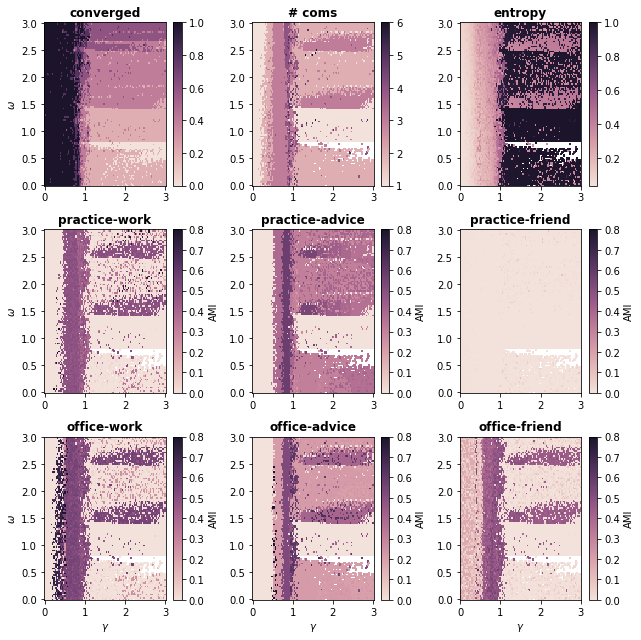

In [47]:
cmap=sbn.cubehelix_palette(light=.9,dark=.1,as_cmap=True)
modbp_obj.retrieval_modularities['converged']=modbp_obj.retrieval_modularities['converged'].astype(float)

rm_df=modbp_obj.retrieval_modularities
print("starting: ",rm_df.shape)
rm_df=rm_df.iloc[np.where(rm_df['converged'])[0],:]
# rm_df=rm_df[np.logical_not(rm_df['is_trivial'].values)]
# We take the partition that has the highest modularity for each resgamma omega pair 
rm_df=rm_df.loc[rm_df.groupby(['resgamma','omega'])['bethe_free_energy'].idxmin().values,:]

modbprm=modbp_obj.retrieval_modularities.groupby(['resgamma','omega']).mean()
rmods_grps=rm_df.groupby(['resgamma','omega']) #these are from the filtered by highest rm 



def array2bins(arr):
    width=arr[1]-arr[0] #assume fix width
    _,edges=np.histogram(arr,bins=len(arr),range=[arr[0]-width*.5,arr[-1]+width*.5])
    return edges
plt.rc('text',usetex=False)

X,Y=np.meshgrid(array2bins(gammas),array2bins(omegas),indexing='ij')
plt.close()

f,a=plt.subplots(3,3,figsize=(9,9))
a=plt.subplot(3,3,1)
p=plt.pcolormesh(X,Y,modbprm['converged'].unstack(),cmap=cmap)
# a.set_xlabel(r'$\gamma$')
a.set_ylabel(r'$\omega$')
plt.colorbar(p)
a.set_title('converged',fontweight='bold')

a=plt.subplot(3,3,2)
# a.set_xlabel(r'$\gamma$')
# a.set_ylabel(r'$\omega$')
p=plt.pcolormesh(X,Y,rmods_grps.mean()['num_coms'].unstack(),cmap=cmap)
plt.colorbar(p)
a.set_title('# coms',fontweight='bold')


a=plt.subplot(3,3,3)
# a.set_xlabel(r'$\gamma$')
# a.set_ylabel(r'$\omega$')
p=plt.pcolormesh(X,Y,rmods_grps.mean()['entropy'].unstack(),cmap=cmap)
plt.colorbar(p)
a.set_title('entropy',fontweight='bold')

max_ami_axis=.8
a=plt.subplot(3,3,4)
# a.set_xlabel(r'$\gamma$')
a.set_ylabel(r'$\omega$')
p=plt.pcolormesh(X,Y,rmods_grps.max()['practice_0'].unstack(),cmap=cmap,vmin=0,vmax=max_ami_axis)
plt.colorbar(p,label='AMI')
a.set_title('practice-work',fontweight='bold')
a=plt.subplot(3,3,5)
# a.set_xlabel(r'$\gamma$')
# a.set_ylabel(r'$\omega$')
p=plt.pcolormesh(X,Y,rmods_grps.max()['practice_1'].unstack(),cmap=cmap,vmin=0,vmax=max_ami_axis)
plt.colorbar(p,label='AMI')
a.set_title('practice-advice',fontweight='bold')
a=plt.subplot(3,3,6)
# a.set_xlabel(r'$\gamma$')
# a.set_ylabel(r'$\omega$')
p=plt.pcolormesh(X,Y,rmods_grps.max()['practice_2'].unstack(),cmap=cmap,vmin=0,vmax=max_ami_axis)
plt.colorbar(p,label='AMI')
a.set_title('practice-friend',fontweight='bold')

a=plt.subplot(3,3,7)
a.set_xlabel(r'$\gamma$')
a.set_ylabel(r'$\omega$')
p=plt.pcolormesh(X,Y,rmods_grps.max()['office_0'].unstack(),cmap=cmap,vmin=0,vmax=max_ami_axis)
plt.colorbar(p,label='AMI')
a.set_title('office-work',fontweight='bold')
a=plt.subplot(3,3,8)
a.set_xlabel(r'$\gamma$')
# a.set_ylabel(r'$\omega$')
p=plt.pcolormesh(X,Y,rmods_grps.max()['office_1'].unstack(),cmap=cmap,vmin=0,vmax=max_ami_axis)
plt.colorbar(p,label='AMI')
a.set_title('office-advice',fontweight='bold')
a=plt.subplot(3,3,9)
a.set_xlabel(r'$\gamma$')
# a.set_ylabel(r'$\omega$')
p=plt.pcolormesh(X,Y,rmods_grps.max()['office_2'].unstack(),cmap=cmap,vmin=0,vmax=max_ami_axis)
plt.colorbar(p,label='AMI')
a.set_title('office-friend',fontweight='bold')


plt.tight_layout()

plt.savefig(os.path.join(outdatdir,'heatmaps_by_layer_AMI_updated.png'),dpi=200)
# plt.savefig(os.path.join(outdatdir,'heatmaps_by_layer_AMI.pdf'))
plt.show()

# Run CHAMP

In [48]:
intragraph,intergraph=champ.create_multilayer_igraph_from_edgelist(interlayer_edges=inter_elist
                                             ,intralayer_edges=intra_elist,
                                             layer_vec=layer_vec)

In [ ]:
crm=modbp_obj.retrieval_modularities
crm=crm.iloc[np.where(crm['converged'])[0],:]
crm=crm.iloc[np.where(np.logical_not(crm['is_trivial']))[0],:]
inds=crm.index
allpartitions=[]
part_ens=champ.louvain_ext.PartitionEnsemble(interlayer_graph=intergraph,graph=intragraph,layer_vec=layer_vec,name='lawyers_ens',maxpt=(3,3))
for ind in inds:
    cpart=modbp_obj.partitions[ind]
    allpartitions.append({'partition':cpart,
                         'orig_mod':crm.loc[ind,'retrieval_modularity'],
                         'resolution':crm.loc[ind,'resgamma'],
                         'coupling':crm.loc[ind,'omega']})
part_ens.add_partitions(allpartitions)
print('CHAMP set {} of {}'.format(len(part_ens.ind2doms),len(part_ens.get_unique_partition_indices())))

In [ ]:
lay2keep

In [ ]:
atts2show=['status','office','practice']
plt.close()
f,a=plt.subplots(2,2,figsize=(12,12))
a=plt.subplot(2,2,1)
part_ens.plot_2d_modularity_domains(ax=a)
a.set_title("CHAMP set")
cmap=sbn.cubehelix_palette(light=.9,dark=.01,as_cmap=True)

def get_max_ami_att_layer(ind,att):
    amis=[]
    for layer in [0,1,2]:
        cinds=np.where(layer_vec==layer)
        amis.append(skm.adjusted_mutual_info_score(part_ens.partitions[ind][cinds],attributes[attributes_dict[att]].values))
#     print(amis)
    return np.mean(amis) #,np.argmax(amis)
    
norm=mc.Normalize(vmin=0,vmax=.6)
for i,att in enumerate(atts2show):
    a=plt.subplot(2,2,i+2)
    attvec=np.concatenate([attributes[attributes_dict[att]] for _ in range(3)])
    amis=map(lambda(x): get_max_ami_att_layer(x,att),part_ens.ind2doms.keys())
    colors=map(lambda(x): cmap(norm(x)) ,amis)
    part_ens.plot_2d_modularity_domains(ax=a,col=colors)
    cax, _ = mcb.make_axes(a)
    cbar = mcb.ColorbarBase(cax, cmap=cmap, norm=norm)
#     part_ens.plot_2d_modularity_domains_with_AMI(ax=a,cmap=cmap,true_part=attvec)
    a.set_title(att)
    plt.suptitle("Layer Avg AMI with different Attributes of CHAMP set",fontweight='bold',fontsize=14)

plt.show()